## Data Prepration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_2022 = pd.read_excel('ttc-bus-delay-data-2022.xlsx')
data_2023 = pd.read_excel('ttc-bus-delay-data-2023.xlsx')
data_2024 = pd.read_excel('ttc-bus-delay-data-2024.xlsx')

In [3]:
data_2022

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle
0,2022-01-01,320,02:00,Saturday,YONGE AND DUNDAS,General Delay,0,0,NaN,8531
1,2022-01-01,325,02:00,Saturday,OVERLEA AND THORCLIFFE,Diversion,131,161,W,8658
2,2022-01-01,320,02:00,Saturday,YONGE AND STEELES,Operations - Operator,17,20,S,0
3,2022-01-01,320,02:07,Saturday,YONGE AND STEELES,Operations - Operator,4,11,S,0
4,2022-01-01,320,02:13,Saturday,YONGE AND STEELES,Operations - Operator,4,8,S,0
...,...,...,...,...,...,...,...,...,...,...
58702,2022-12-31,32,23:21,Saturday,EGLINTON AND EDITH (W,Mechanical,2,24,W,1085
58703,2022-12-31,113,23:28,Saturday,DANFORTH AND DAWES,Vision,20,40,W,8589
58704,2022-12-31,72,23:56,Saturday,LOWER SHERBOURNE AND L,Security,18,36,N,8493
58705,2022-12-31,22,00:17,Saturday,BINGHAM LOOP,Cleaning - Unsanitary,10,20,S,8582


In [4]:
combined_data = pd.concat([data_2022, data_2023], ignore_index=True)

In [ ]:
# Convert both 'Date' and 'Time' columns to string type before concatenation
combined_data['DateTime'] = pd.to_datetime(combined_data['Date'].astype(str) + ' ' + combined_data['Time'].astype(str))
data_2024['DateTime'] = pd.to_datetime(data_2024['Date'].astype(str) + ' ' + data_2024['Time'].astype(str))
data_2024.set_index('DateTime', inplace=True)
# Set 'DateTime' as the index
combined_data.set_index('DateTime', inplace=True)

# Aggregate 'Min Delay' by hour (you can change 'H' to 'D' for daily aggregation)
hourly_delay = combined_data['Min Delay'].resample('H').mean()

# Fill any missing values (if there are gaps in the time series)
hourly_delay = hourly_delay.fillna(hourly_delay.mean())

hourly_delay

/tmp/ipykernel_16268/2714583785.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_delay = combined_data['Min Delay'].resample('H').mean()


DateTime
2022-01-01 00:00:00    18.500000
2022-01-01 01:00:00    19.600000
2022-01-01 02:00:00    21.555556
2022-01-01 03:00:00    15.500000
2022-01-01 04:00:00    21.200000
                         ...    
2023-12-31 19:00:00    20.000000
2023-12-31 20:00:00    25.375000
2023-12-31 21:00:00    17.714286
2023-12-31 22:00:00    16.000000
2023-12-31 23:00:00    16.250000
Freq: h, Name: Min Delay, Length: 17520, dtype: float64

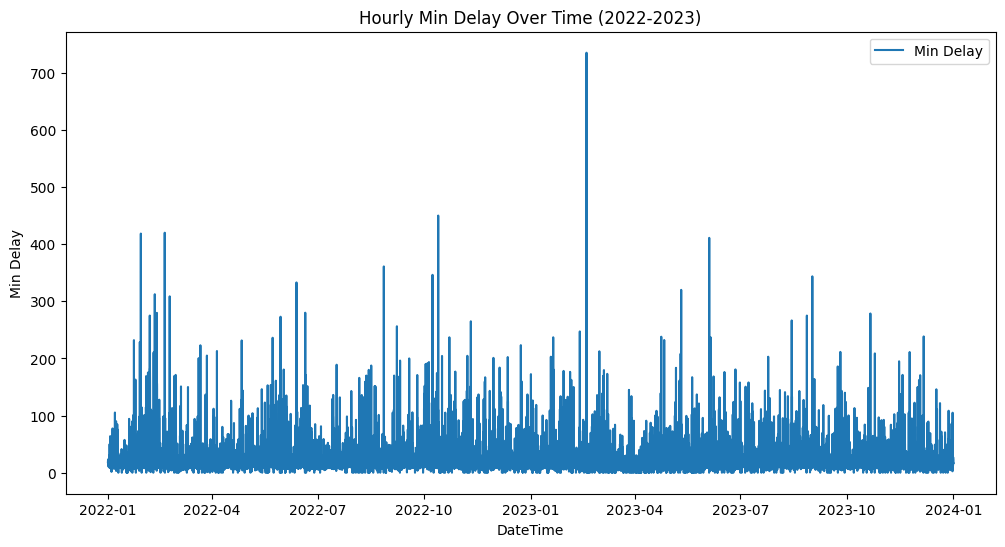

In [6]:
import matplotlib.pyplot as plt

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(hourly_delay, label='Min Delay')
plt.title('Hourly Min Delay Over Time (2022-2023)')
plt.xlabel('DateTime')
plt.ylabel('Min Delay')
plt.legend()
plt.show()

In [9]:
daily_delay = combined_data['Min Delay'].resample('D').mean()
daily_delay = daily_delay.fillna(daily_delay.mean())

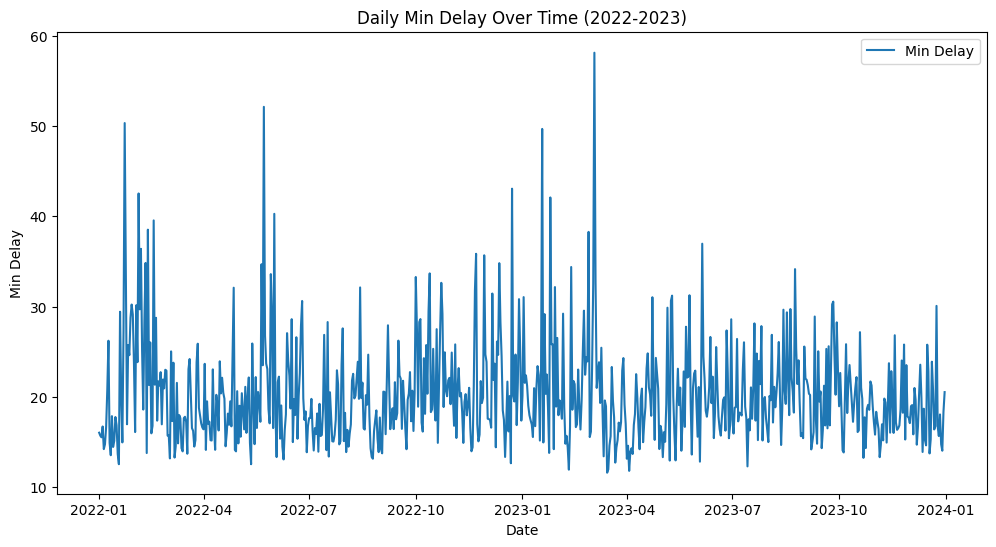

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(daily_delay, label='Min Delay')
plt.title('Daily Min Delay Over Time (2022-2023)')
plt.xlabel('Date')
plt.ylabel('Min Delay')
plt.legend()
plt.show()

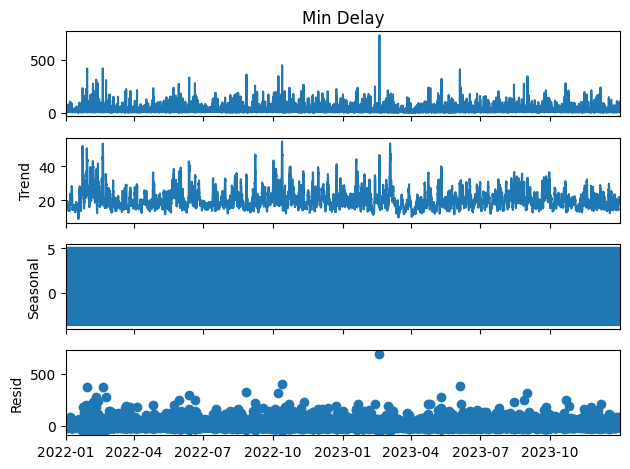

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(hourly_delay, model='additive', period=24)  # Assuming daily seasonality (24 hours)

# Plot the decomposition
decomposition.plot()
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(hourly_delay.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Interpret the result
if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary. Apply differencing.")

ADF Statistic: -22.918999049003634
p-value: 0.0
Critical Values: {'1%': -3.430723835937905, '5%': -2.861705221042745, '10%': -2.5668579428728298}
The time series is stationary.


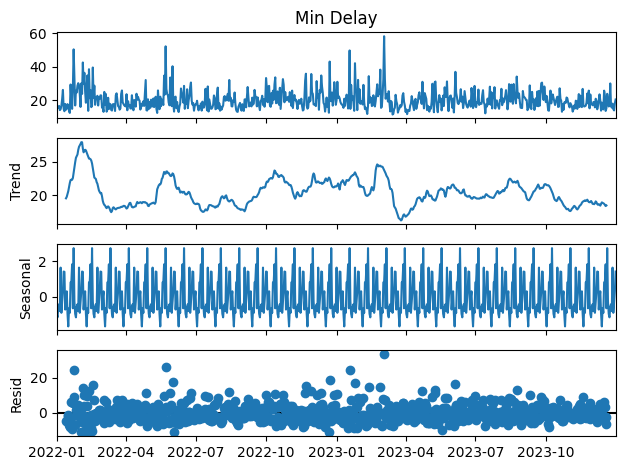

In [10]:
# Decompose the time series
decomposition2 = seasonal_decompose(daily_delay, model='additive', period=24)  # Assuming daily seasonality (24 hours)

# Plot the decomposition
decomposition2.plot()
plt.show()

In [11]:
# Perform ADF test
result = adfuller(daily_delay.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Interpret the result
if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary. Apply differencing.")

ADF Statistic: -7.0806319340296655
p-value: 4.676504915817321e-10
Critical Values: {'1%': -3.4394269973845657, '5%': -2.8655458544300387, '10%': -2.568903174551249}
The time series is stationary.


In [16]:
from pmdarima import auto_arima

# Automatically find the best ARIMA parameters
model = auto_arima(daily_delay, seasonal=True, m=7, stepwise=True, trace=True)
# Display the model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=4616.336, Time=1.69 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=4626.129, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=4578.337, Time=0.52 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=4582.401, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=6526.846, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=4593.693, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=4580.188, Time=1.62 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=4580.369, Time=1.14 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=4579.216, Time=0.35 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=4582.296, Time=2.35 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=4606.671, Time=0.30 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=4578.575, Time=0.56 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=4575.256, Time=1.06 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=4580.584, Time=0.55 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept

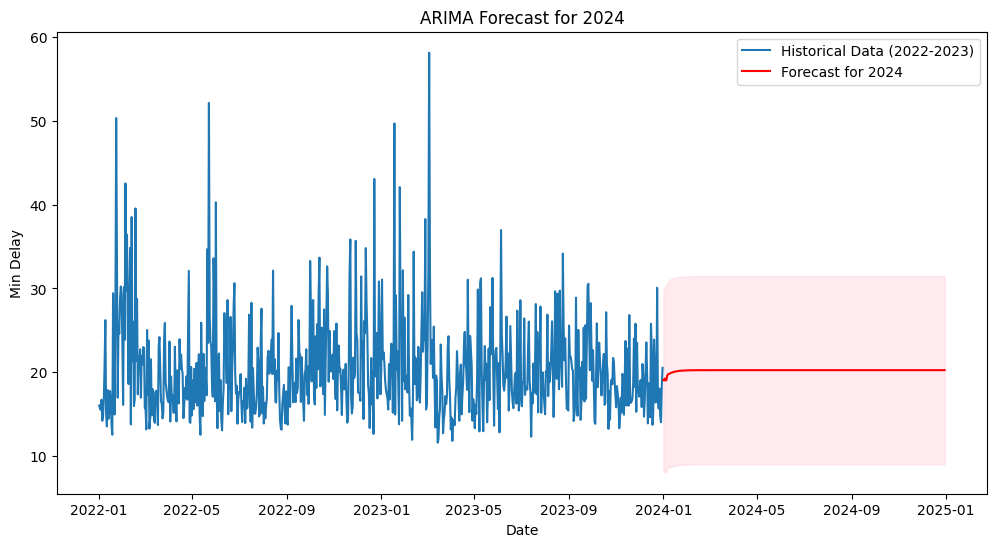

In [17]:
# Forecast for the entire year of 2024
forecast_steps = 365  # 365 days
forecast, conf_int = model.predict(n_periods=forecast_steps, return_conf_int=True)

# Create a date range for 2024
forecast_index = pd.date_range(start='2024-01-01', periods=forecast_steps, freq='D')

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(daily_delay.index, daily_delay, label='Historical Data (2022-2023)')
plt.plot(forecast_index, forecast, label='Forecast for 2024', color='red')
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast for 2024')
plt.xlabel('Date')
plt.ylabel('Min Delay')
plt.legend()
plt.show()

In [20]:
# Aggregate 'Min Delay' by day
daily_delay_2024 = data_2024['Min Delay'].resample('D').mean()

# Fill any missing values (if there are gaps in the time series)
daily_delay_2024 = daily_delay_2024.fillna(daily_delay_2024.mean())

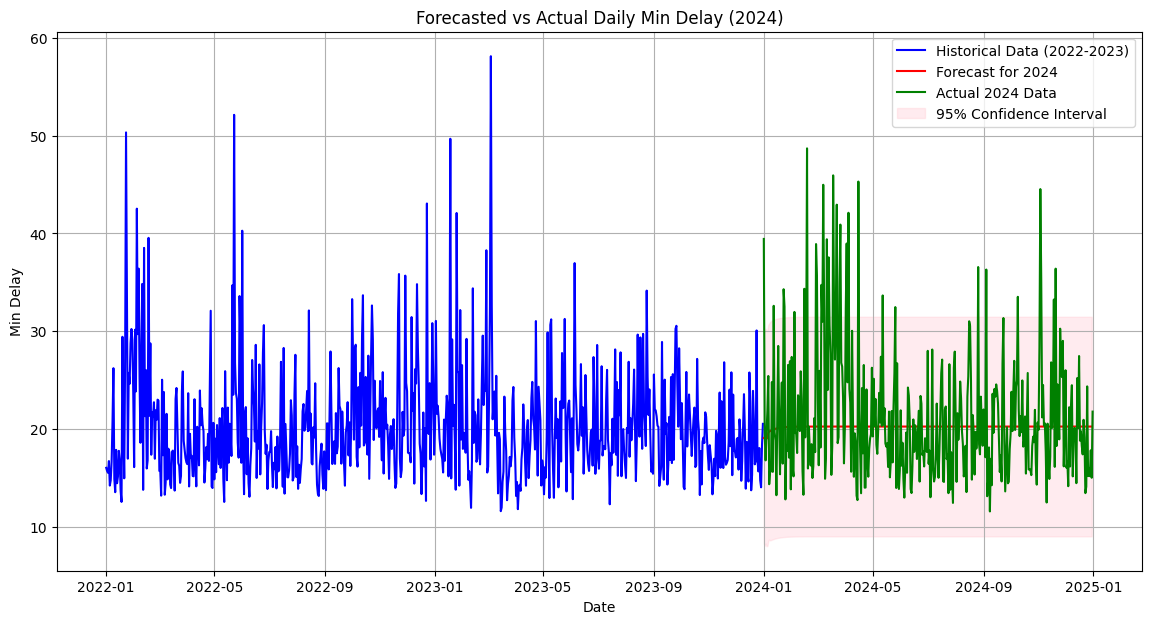

In [21]:
import matplotlib.pyplot as plt

# Plot the historical data (2022-2023)
plt.figure(figsize=(14, 7))
plt.plot(daily_delay.index, daily_delay, label='Historical Data (2022-2023)', color='blue')

# Plot the forecasted data (2024)
plt.plot(forecast_index, forecast, label='Forecast for 2024', color='red')

# Plot the actual 2024 data
plt.plot(daily_delay_2024.index, daily_delay_2024, label='Actual 2024 Data', color='green')

# Add confidence intervals
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

# Add labels and title
plt.title('Forecasted vs Actual Daily Min Delay (2024)')
plt.xlabel('Date')
plt.ylabel('Min Delay')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Manually specify SARIMAX parameters
model = SARIMAX(
    daily_delay,
    order=(1, 1, 1),          # (p, d, q)
    seasonal_order=(1, 1, 1, 7)  # (P, D, Q, m) for weekly seasonality
)
model_fit = model.fit(disp=False)

# Forecast for 2024
forecast = model_fit.forecast(steps=365)

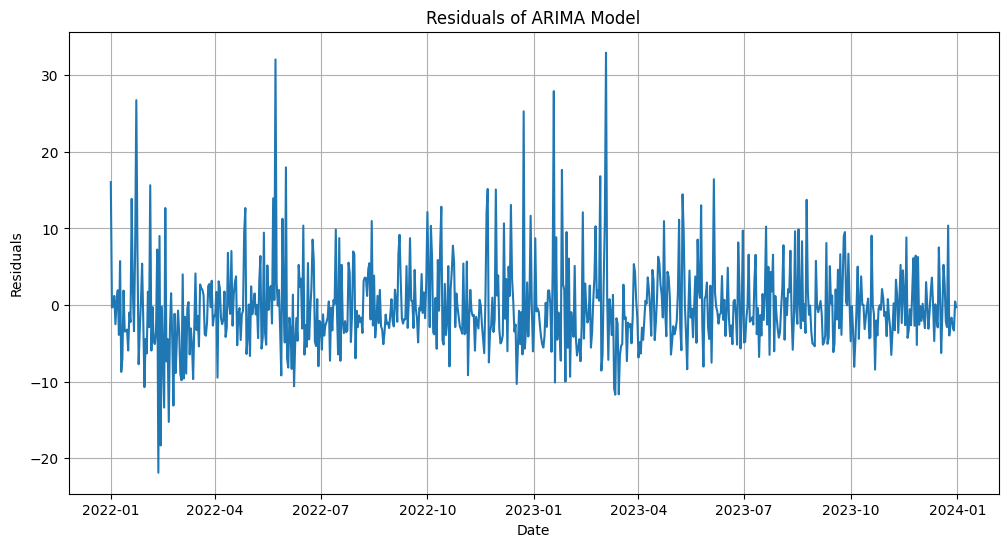

In [24]:
# Get residuals from the ARIMA model
residuals = model_fit.resid

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

/workspaces/projects/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
05:17:26 - cmdstanpy - INFO - Chain [1] start processing
05:17:26 - cmdstanpy - INFO - Chain [1] done processing


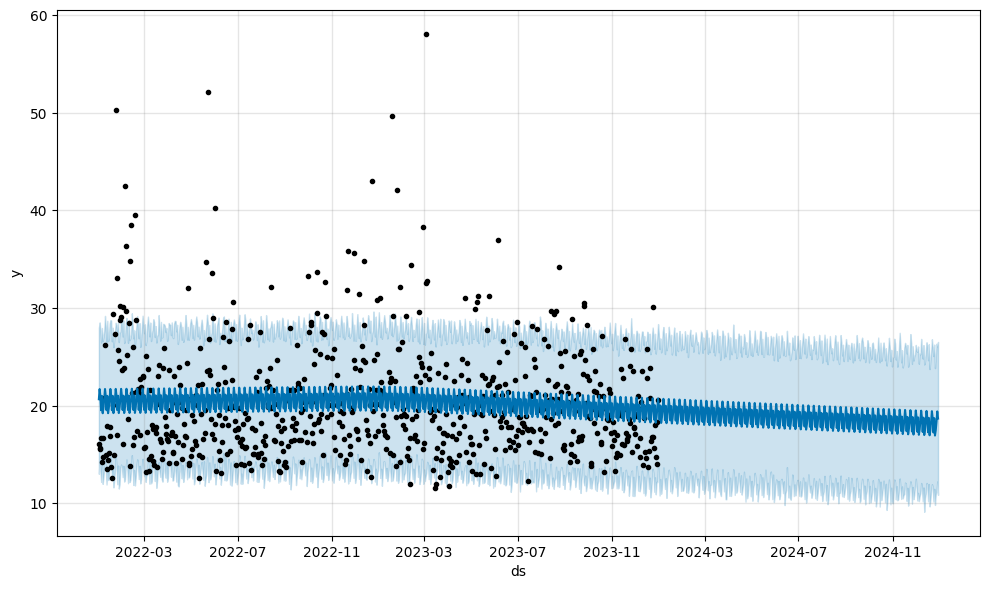

In [25]:
from prophet import Prophet

# Prepare data for Prophet
prophet_data = daily_delay.reset_index()
prophet_data.columns = ['ds', 'y']

# Fit Prophet model
model = Prophet()
model.fit(prophet_data)

# Forecast for 2024
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.show()